In [230]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import torch
import pickle
import timm
from ModelAnalysis import load_model_from_timm, load_default_input_tensor_for_model
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from torch.autograd.profiler_util import FunctionEventAvg
from tqdm.autonotebook import tqdm as notebook_tqdm
from timeit import timeit
import torchvision
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math

In [239]:
# def calculate_speedup(model_name, clk_freq):
model_name = 'beit_base_patch16_224'
result_df = pd.read_csv('../data/timm.csv')
model = result_df.query(f'model_name == \'{model_name}\'')
profile_df = pd.read_csv(f'../data/profiling/{model_name}.csv', index_col=0)

In [261]:
cpu_profiling_basepath = Path('../data/profiling')
arch_results_basepath = Path('../data/arch_results')

min_speedup = math.inf
max_speedup = -math.inf

avg_model_speedup = {}
avg_compute_of_supported_layers = []
for model_name in notebook_tqdm(os.listdir(arch_results_basepath)):
    model_path = os.path.join(arch_results_basepath, model_name)
    profile_path = os.path.join(cpu_profiling_basepath, model_name)
    arch_metrics = pd.read_csv(model_path, index_col=0)
    cpu_profile_results = pd.read_csv(profile_path, index_col = False).iloc[:, 1:]
    cpu_profile_results = cpu_profile_results.set_index('Layer Name')
    layers_simulated = arch_metrics.to_dict('index')
    layer_speedup = []
    avg_model_speedup[model_name] = {}
    cpu_runtime = 0
    for layer in layers_simulated.keys():
        cpu_dur_ns = cpu_profile_results.loc[layer, 'Duration']*10**3
        arch_dur_ns = arch_metrics.loc[layer, 'latency']
        speedup = cpu_dur_ns / arch_dur_ns
        cpu_runtime += cpu_dur_ns
        avg_model_speedup[model_name][layer] = speedup
        if speedup < min_speedup:
            min_speedup = speedup
            slowest_layer = (model_name, layer)
        if speedup > max_speedup:
            max_speedup = speedup
            fastest_layer = (model_name, layer)
    percent_of_compute = cpu_runtime / 

SyntaxError: invalid syntax (1157718237.py, line 20)

In [ ]:
avg_compute_of_supported_layers = np.average()

In [245]:
res = []
for _, layer_speedup_list in avg_model_speedup.items():
    res.append(list(layer_speedup_list.values()))

In [260]:
speedup_list = []
for _, layer_speedup_list in avg_model_speedup.items():
    speedup_list.extend(layer_speedup_list.values())

median_layer_speedup = np.quantile(speedup_list, q = 0.5)
median_layer_speedup

4.819957693804431

In [253]:
median_model_speedup = np.quantile([np.average(list(layer_speedup_list.values())) for _, layer_speedup_list in avg_model_speedup.items()], q = 0.5)
median_model_speedup

14.990034070960567

In [241]:
np.quantile(avg_model_speedup, q=0.5)

TypeError: unsupported operand type(s) for -: 'dict' and 'dict'

/home/sultan_dev/.pyenv/versions/3.9.5/envs/hero-sim-backend/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-10.0, 5000.0)

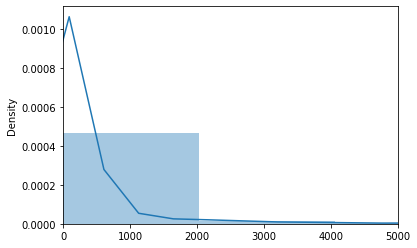

In [223]:
plt = se.distplot(x = avg_model_speedup)
plt.set_xlim(-10, 5000)

In [181]:
model_layer_names_without_decomposition = set()
for name in model["layer_name"].to_list():
    name_without_decomposition_indicators = r".".join(name.split(".")[:-2])
    model_layer_names_without_decomposition.add(name_without_decomposition_indicators)
model_layer_names_without_decomposition = list(model_layer_names_without_decomposition)

In [10]:
for evaluated_model in set(result_df['model_name'].to_list()):
    acc_results_df = result_df.query(f'model_name == \'{evaluated_model}\'')
    profile_df = pd.read_csv(f'../data/profiling/{evaluated_model}.csv')
    

695

In [24]:
def calculate_bw(model_name, clk_freq):
    model = result_df.query(f'model_name == \'{model_name}\'')
    load_bw = model['dram_load'] / model['latency'] * clk_freq
    store_bw = model['dram_store'] / model['latency'] * clk_freq
    return load_bw, store_bw

In [98]:
def calculate_latency(model_name, clk_freq):
    model = result_df.query(f'model_name == \'{model_name}\'')
    latency = np.sum(model['latency'])
    return latency * 1 / clk_freq *10**6
def estimate_fps(model_name, clk_freq):
    latency_in_seconds = calculate_latency(model_name, clk_freq)
    return 1/latency_in_seconds

In [99]:
calculate_latency('resnet50', clk)

15870.309

In [28]:
arch_max_consume_bw = 18 * clk / 2**30
arch_max_produce_bw = 32 * 2 * clk / 2**30

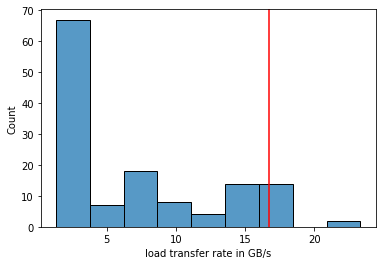

In [52]:
load_bw, store_bw = calculate_bw('hrnet_w18_small', clk) 
load_bw, store_bw = load_bw/ 2**30, store_bw * 2/ 2**30 # assuming 2 bytes/ ofmap
plt = se.histplot(data=pd.DataFrame({'load transfer rate in GB/s': load_bw}), x='load transfer rate in GB/s')
plt.axvline(arch_max_consume_bw, color='r')

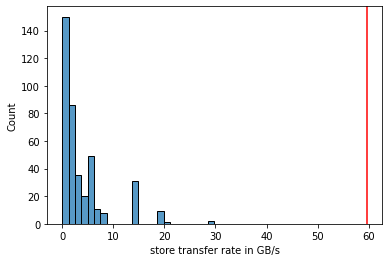

In [30]:
plt = se.histplot(data=pd.DataFrame({'store transfer rate in GB/s': store_bw}), x='store transfer rate in GB/s')
plt.axvline(arch_max_produce_bw, color='r')

In [94]:
resnet50 = pickle.load(open("../data/processed_models/resnet50.model.pickle", "rb"))
kernel_sizes = Counter()
for layer_name, layer in resnet50.items():
    ifmap_dims, layer_obj = layer
    try:
        kernel_sizes.update({layer_obj.kernel_size[0]: 1})
    except AttributeError as e:
        kernel_sizes.update({1: 1})
kernel_sizes

Counter({7: 1, 1: 37, 3: 16})